In [ ]:
import numpy as np
import pandas as pd
import boto3
from botocore import UNSIGNED
from botocore.config import Config

In [2]:
df = pd.read_parquet('processed_data/photo_roi_mammals.parquet')
df['name'] = df['name'].astype('category')
df['name'] = df['name'].str.lower().str.replace(' ', '_')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245910 entries, 0 to 245909
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   photo_id  245910 non-null  int64 
 1   name      245910 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.8+ MB


In [4]:
df.isna().sum(axis=0)

photo_id    0
name        0
dtype: int64

In [5]:
df.describe()

,photo_id
count,2.459100e+05
mean,1.619677e+08
std,9.628184e+07
min,4.172000e+03
25%,8.555626e+07
50%,1.540647e+08
75%,2.440588e+08
max,3.481715e+08


In [6]:
df['name'].value_counts().head(50)

name
odocoileus_virginianus      36490
sciurus_carolinensis        31013
tamiasciurus_hudsonicus     18668
tamias_striatus             16050
canis_latrans               12377
sylvilagus_floridanus       11909
vulpes_vulpes               11508
procyon_lotor               11488
castor_canadensis            9312
marmota_monax                7475
ondatra_zibethicus           5660
erethizon_dorsatum           5558
alces_alces                  4972
neogale_vison                4540
ursus_americanus             4291
lepus_americanus             3664
mephitis_mephitis            3413
lontra_canadensis            3347
pekania_pennanti             2520
blarina_brevicauda           2285
peromyscus                   2123
microtus_pennsylvanicus      1734
felis_catus                  1619
didelphis_virginiana         1582
canis_familiaris             1515
urocyon_cinereoargenteus     1358
lynx_rufus                   1241
homo_sapiens                 1148
eptesicus_fuscus             1107
carnivora

<Axes: ylabel='Frequency'>

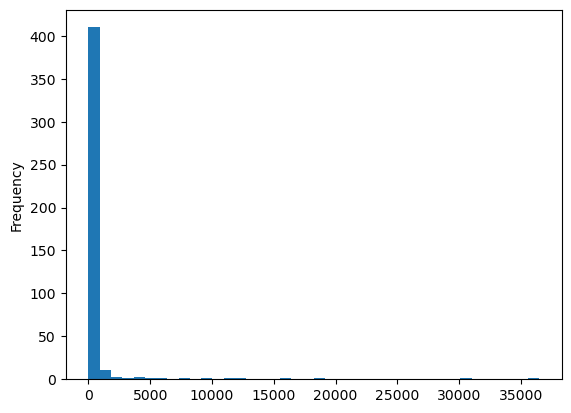

In [7]:
df['name'].value_counts().plot(kind='hist', bins=40)

In [8]:
df['name_number_of_observation'] = df.groupby('name').transform(lambda x: x.count())

In [9]:
df = df.query('name_number_of_observation>500')

In [10]:
df_sample = df.iloc[:50000]

In [11]:
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [12]:
df_sample['downloaded'] = False
for row in df_sample.itertuples():
    name = f'photos/{row[1]}_{row[2]}.jpg'
    try:
        try:
            key = f'photos/{row[1]}/medium.jpeg'
            s3.download_file('inaturalist-open-data', key, name)
            df_sample['downloaded'].iloc[row[0]] = True
        except:
            key = f'photos/{row[1]}/medium.jpg'
            s3.download_file('inaturalist-open-data', key, name)
            df_sample['downloaded'].iloc[row[0]] = True

    except:
        df_sample['downloaded'] = True
        print(f"Issue with {key}")


/var/folders/3b/cqk0ghz91fv_94kdrrxl1wcm0000gn/T/ipykernel_5715/3929985999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['downloaded'] = False
/var/folders/3b/cqk0ghz91fv_94kdrrxl1wcm0000gn/T/ipykernel_5715/3929985999.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['downloaded'] = True


Issue with photos/51055/medium.jpg
Issue with photos/58672/medium.jpg
Issue with photos/58677/medium.jpg
Issue with photos/58687/medium.jpg
Issue with photos/58692/medium.jpg
Issue with photos/58889/medium.jpg
Issue with photos/67660/medium.jpg
Issue with photos/68461/medium.jpg
Issue with photos/70549/medium.jpg
Issue with photos/106706/medium.jpg
Issue with photos/106708/medium.jpg
Issue with photos/106710/medium.jpg
Issue with photos/106721/medium.jpg
Issue with photos/106756/medium.jpg
Issue with photos/113806/medium.jpg
Issue with photos/118595/medium.jpg
Issue with photos/128721/medium.jpg
Issue with photos/128733/medium.jpg
Issue with photos/147186/medium.jpg
Issue with photos/147368/medium.jpg
Issue with photos/149461/medium.jpg
Issue with photos/150167/medium.jpg
Issue with photos/150122/medium.jpg
Issue with photos/168082/medium.jpg
Issue with photos/180009/medium.jpg
Issue with photos/180016/medium.jpg
Issue with photos/180580/medium.jpg
Issue with photos/208562/medium.jpg
I

In [13]:
df_sample

,photo_id,name,name_number_of_observation,downloaded
0,44643,alces_alces,4972,True
1,45208,sciurus_carolinensis,31013,True
2,45604,ursus_americanus,4291,True
3,50829,homo_sapiens,1148,True
4,51055,odocoileus_virginianus,36490,True
...,...,...,...,...
53416,74540667,tamias_striatus,16050,True
53417,74543911,odocoileus_virginianus,36490,True
53418,74545233,vulpes_vulpes,11508,True
53419,74546245,leporidae,522,True


In [15]:
df_sample.to_parquet('download_photos.parquet')

In [19]:
pd.read_parquet('download_photos.parquet')['downloaded'].value_counts()

downloaded
True    50000
Name: count, dtype: int64

In [26]:
file = 'imported_photos.txt'

In [65]:
not_downloaded = np.array([])
with open(file) as f:
    for line in f:
        not_downloaded = np.append(not_downloaded, line.split('/')[1])


In [71]:
not_downloaded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2398 entries, 0 to 2397
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   photo_id    2398 non-null   object
 1   downloaded  2398 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 21.2+ KB


In [68]:
not_downloaded['downloaded'] = False

In [81]:
not_downloaded['photo_id'] = not_downloaded['photo_id'].astype(int)

In [82]:
df_sample = pd.merge(df_sample, not_downloaded, on='photo_id', how = 'left')

In [83]:
df_sample

,photo_id,name,name_number_of_observation,downloaded_x,downloaded_y,downloaded
0,44643,alces_alces,4972,True,NaN,NaN
1,45208,sciurus_carolinensis,31013,True,NaN,NaN
2,45604,ursus_americanus,4291,True,NaN,NaN
3,50829,homo_sapiens,1148,True,NaN,NaN
4,51055,odocoileus_virginianus,36490,True,NaN,False
...,...,...,...,...,...,...
49999,74540667,tamias_striatus,16050,True,NaN,NaN
50000,74543911,odocoileus_virginianus,36490,True,NaN,NaN
50001,74545233,vulpes_vulpes,11508,True,NaN,NaN
50002,74546245,leporidae,522,True,NaN,NaN


In [89]:
df_sample['downloaded'].value_counts()

downloaded
True     47602
False     2402
Name: count, dtype: int64

In [109]:
classes = sorted(df_sample['name'].unique())

In [113]:
for animal_class in classes:
    new_directory = f'photos/{animal_class}'
    os.makedirs(new_directory, exist_ok=True)